In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from ramannoodles import spectrafit
from ramannoodles import shoyu

In [2]:
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys
sorted(shoyu_data_dict.keys())

['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMIC ACID',
 'WATER']

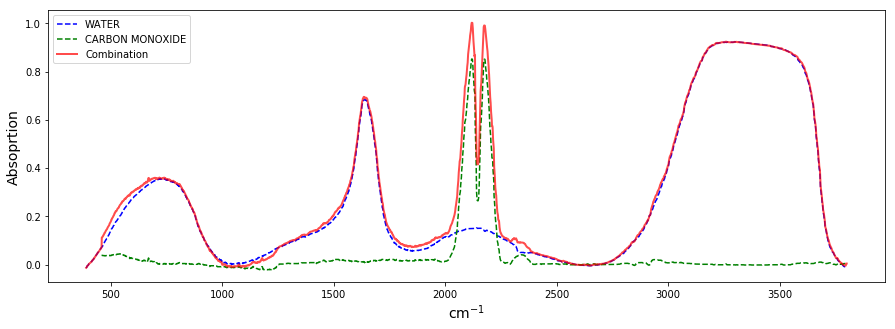

In [3]:
compound_1 = shoyu_data_dict['WATER']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
compound_3 = shoyu_data_dict['ETHYL ALCOHOL']
compound_4 = shoyu_data_dict['FORMIC ACID']
compound_5 = shoyu_data_dict['CARBON DIOXIDE']
spectra_x, spectra_y = shoyu.combine_spectra(compound_1, compound_2, plot = True)

In [4]:
spectra_x = np.asarray(spectra_x)
spectra_y = np.asarray(spectra_y)

In [5]:
water_peaks = spectrafit.compound_report(compound_1)[0]
co_peaks = spectrafit.compound_report(compound_2)[0]
spectra_peaks = spectrafit.data_report(spectra_x, spectra_y)[0]

In [6]:
ethyl_alcohol_peaks = spectrafit.compound_report(compound_3)[0]
formic_acid_peaks = spectrafit.compound_report(compound_4)[0]

In [7]:
print('Water peaks = {}'.format(water_peaks))
print('CO peaks = {}'.format(co_peaks))
print('Combined Spectra peaks = {}'.format(spectra_peaks))
print('EtOH Spectra peaks = {}'.format(ethyl_alcohol_peaks))
print('formic acid peaks = {}'.format(formic_acid_peaks))

Water peaks = [711.4826030832157, 1638.6886199554203, 3312.1231809302135]
CO peaks = [2109.8548231081886, 2183.58416497579]
Combined Spectra peaks = [708.0, 1638.5198632531205, 2110.0000000000095, 2184.149153919652, 3268.999999970273]
EtOH Spectra peaks = [2.757938608767363, 3.4216112107197514, 7.161978013820123, 8.065277519813382, 9.4628771518764, 15.50571824967875]
formic acid peaks = [639.4717630407281, 700.0006725956375, 916.1238150000007, 1087.4292631196167, 1110.229302896255, 1120.6184463323998, 1211.60193448746, 1365.6941683529176, 1531.5978300000031, 1556.2422171904652, 1664.266539247223, 1732.780516872577, 1765.3434260000004, 1791.8601399436195, 2954.071404999994, 3117.188835832671]


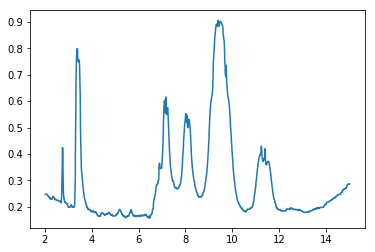

In [8]:
#OK, so the EtOH peaks look very wrong on the x-axis, though the peak positions are just fine I guess? 
plt.plot(compound_3['x'], compound_3['y'])

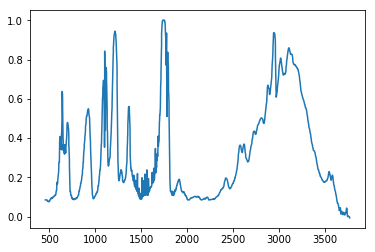

In [9]:
plt.plot(compound_4['x'], compound_4['y'])

In [11]:
known_compound_list = [compound_1, compound_2, compound_4]
known_compound_list[0]['title']
print(spectrafit.compound_report(known_compound_list[1])[0])
len(known_compound_list)

[2109.8548231081886, 2183.58416497579]


3

In [13]:
known_compound_list

[{'title': 'WATER',
  'jcamp-dx': 4.24,
  'data type': 'INFRARED SPECTRUM',
  'class': 'COBLENTZ III',
  'origin': 'DOW CHEMICAL COMPANY',
  'owner': 'COBLENTZ SOCIETY',
  'date': '1969/10/21',
  'cas registry no': '7732-18-5',
  'molform': 'H2 O',
  'source reference': 'COBLENTZ NO. 10116',
  '$nist source': 'COBLENTZ',
  '$nist image': 'cob10116',
  'spectrometer/data system': 'DOW KBr FOREPRISM-GRATING',
  'instrument parameters': 'BLAZED AT 3.5, 12.0, 20.0 MICRON, CHANGED AT 5.0, 7.5, 14.9 MICRON',
  'state': 'LIQUID (NEAT)',
  'path length': 'CAPILLARY, AgCl PLATES',
  'sampling procedure': 'TRANSMISSION',
  'resolution': 4,
  'data processing': 'DIGITIZED BY NIST FROM HARD COPY (FROM TWO SEGMENTS)',
  'xunits': '1/CM',
  'yunits': 'ABSORBANCE',
  'xfactor': 1.0,
  'yfactor': 1,
  'deltax': 0.870985,
  'firstx': 388.677,
  'lastx': 3799.46,
  'firsty': 0.438,
  'maxx': 3799.46,
  'minx': 388.677,
  'maxy': 0.987,
  'miny': 0.001,
  'npoints': 3917,
  'xydata': '(X++(Y..Y))',
  'en

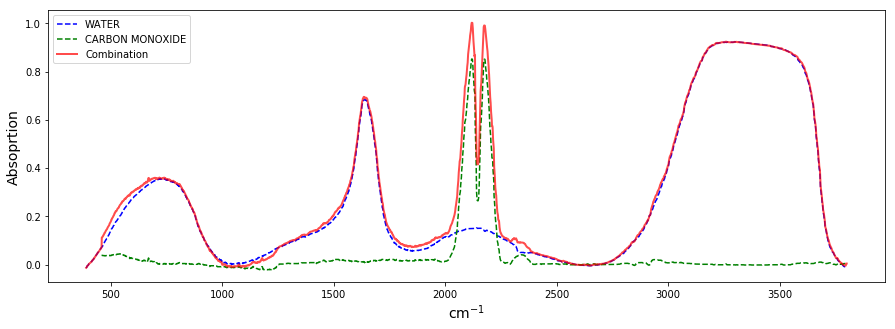

In [14]:
#Generate the unknown spectra by combining two spectra. 
spectra_x, spectra_y = shoyu.combine_spectra(compound_1, compound_2, plot = True)
spectra_x = np.asarray(spectra_x)
spectra_y = np.asarray(spectra_y)

In [51]:
#Writing a wrapper function that calls stuff and keeps everything organized. 
def peak_assignment(unknown_x, unknown_y, known_compound_list, precision = 0.03, plot = True):
    """This function is a wrapper function from which all classification of peaks occurs."""
    #Lets identify the peaks in the unknown spectrum. 
    unknown_peaks = spectrafit.data_report(unknown_x, unknown_y)[0]
    
    #OK, next identify all of the peaks present in the known compound set. 
    #For efficiency, we'll also compare them against the unknown in the same for loop.
    known_compound_peaks = []
    assignment_matrix = []
    
    for i in range(len(known_compound_list)):
        known_compound_peaks.append(spectrafit.compound_report(known_compound_list[i])[0])
        print("The peaks that we found for " + str(known_compound_list[i]['title']) + " are: ")
        print(known_compound_peaks[i])
        assignment_matrix.append(compare_unknown_to_known(unknown_peaks, known_compound_peaks[i], precision))
    
    #Ok, so that generates a full association matrix that contains everything we need to assign peaks. 
    #Now, let's go through and actually assign text to peaks. 
    unknown_peak_assignments = peak_position_comparisons(unknown_peaks, known_compound_peaks, known_compound_list, assignment_matrix)
    print(unknown_peak_assignments)
    
    if plot:
        plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments)
    
    percentages = percentage_of_peaks_found(known_compound_peaks, assignment_matrix, known_compound_list)
    print(percentages)

In [16]:
def compare_unknown_to_known(combined_peaks, known_peaks, precision):
    """This function takes in peak positions for the spectrum to be analyzed and a single known compound and 
    determines if the peaks found in the known compound are present in the unknown spectrum."""
    assignment_matrix = np.zeros(len(combined_peaks))
    peaks_found = 0
    for i in range(len(combined_peaks)):
        for j in range(len(known_peaks)):
            #instead of If, call peak_1D_score
            if math.isclose(combined_peaks[i], known_peaks[j], rel_tol = precision):
                #Instead of using a 1, just input the score from the score calculator. Bigger is better.
                #Storing only the second component in the list. 
                assignment_matrix[i] = 1
                peaks_found += 1
                continue
            else:
                pass
        if peaks_found == len(known_peaks):
            continue
        else:
            pass
    return assignment_matrix

In [19]:
def peak_position_comparisons(unknown_peaks, known_compound_peaks, known_compound_list, association_matrix):
    """This function takes in an association matrix and turns the numbers given by said matrix into 
    a text label."""
    unknown_peak_assignment = []
    #Step through the unknown peaks to make an assignment for each unknown peak. 
    
    for i in range(len(unknown_peaks)):
        #We might be able to make a small performance improvement if we were to somehow 
        #not search the peaks we already had searched, but that seems to not be trivial. 
        position_assignment = []
        #We'll need an outer loop that walks through all the different compound positions
        for j in range(len(known_compound_peaks)): 
            if association_matrix[j][i] == 1:
                position_assignment.append(known_compound_list[j]['title'])
            else:
                pass
        unknown_peak_assignment.append(position_assignment)
    
    return unknown_peak_assignment

The peaks that we found for WATER are: 
[711.4826030832157, 1638.6886199554203, 3312.1231809302135]
The peaks that we found for CARBON MONOXIDE are: 
[2109.8548231081886, 2183.58416497579]
[['WATER'], ['WATER'], ['CARBON MONOXIDE'], ['CARBON MONOXIDE'], ['WATER']]


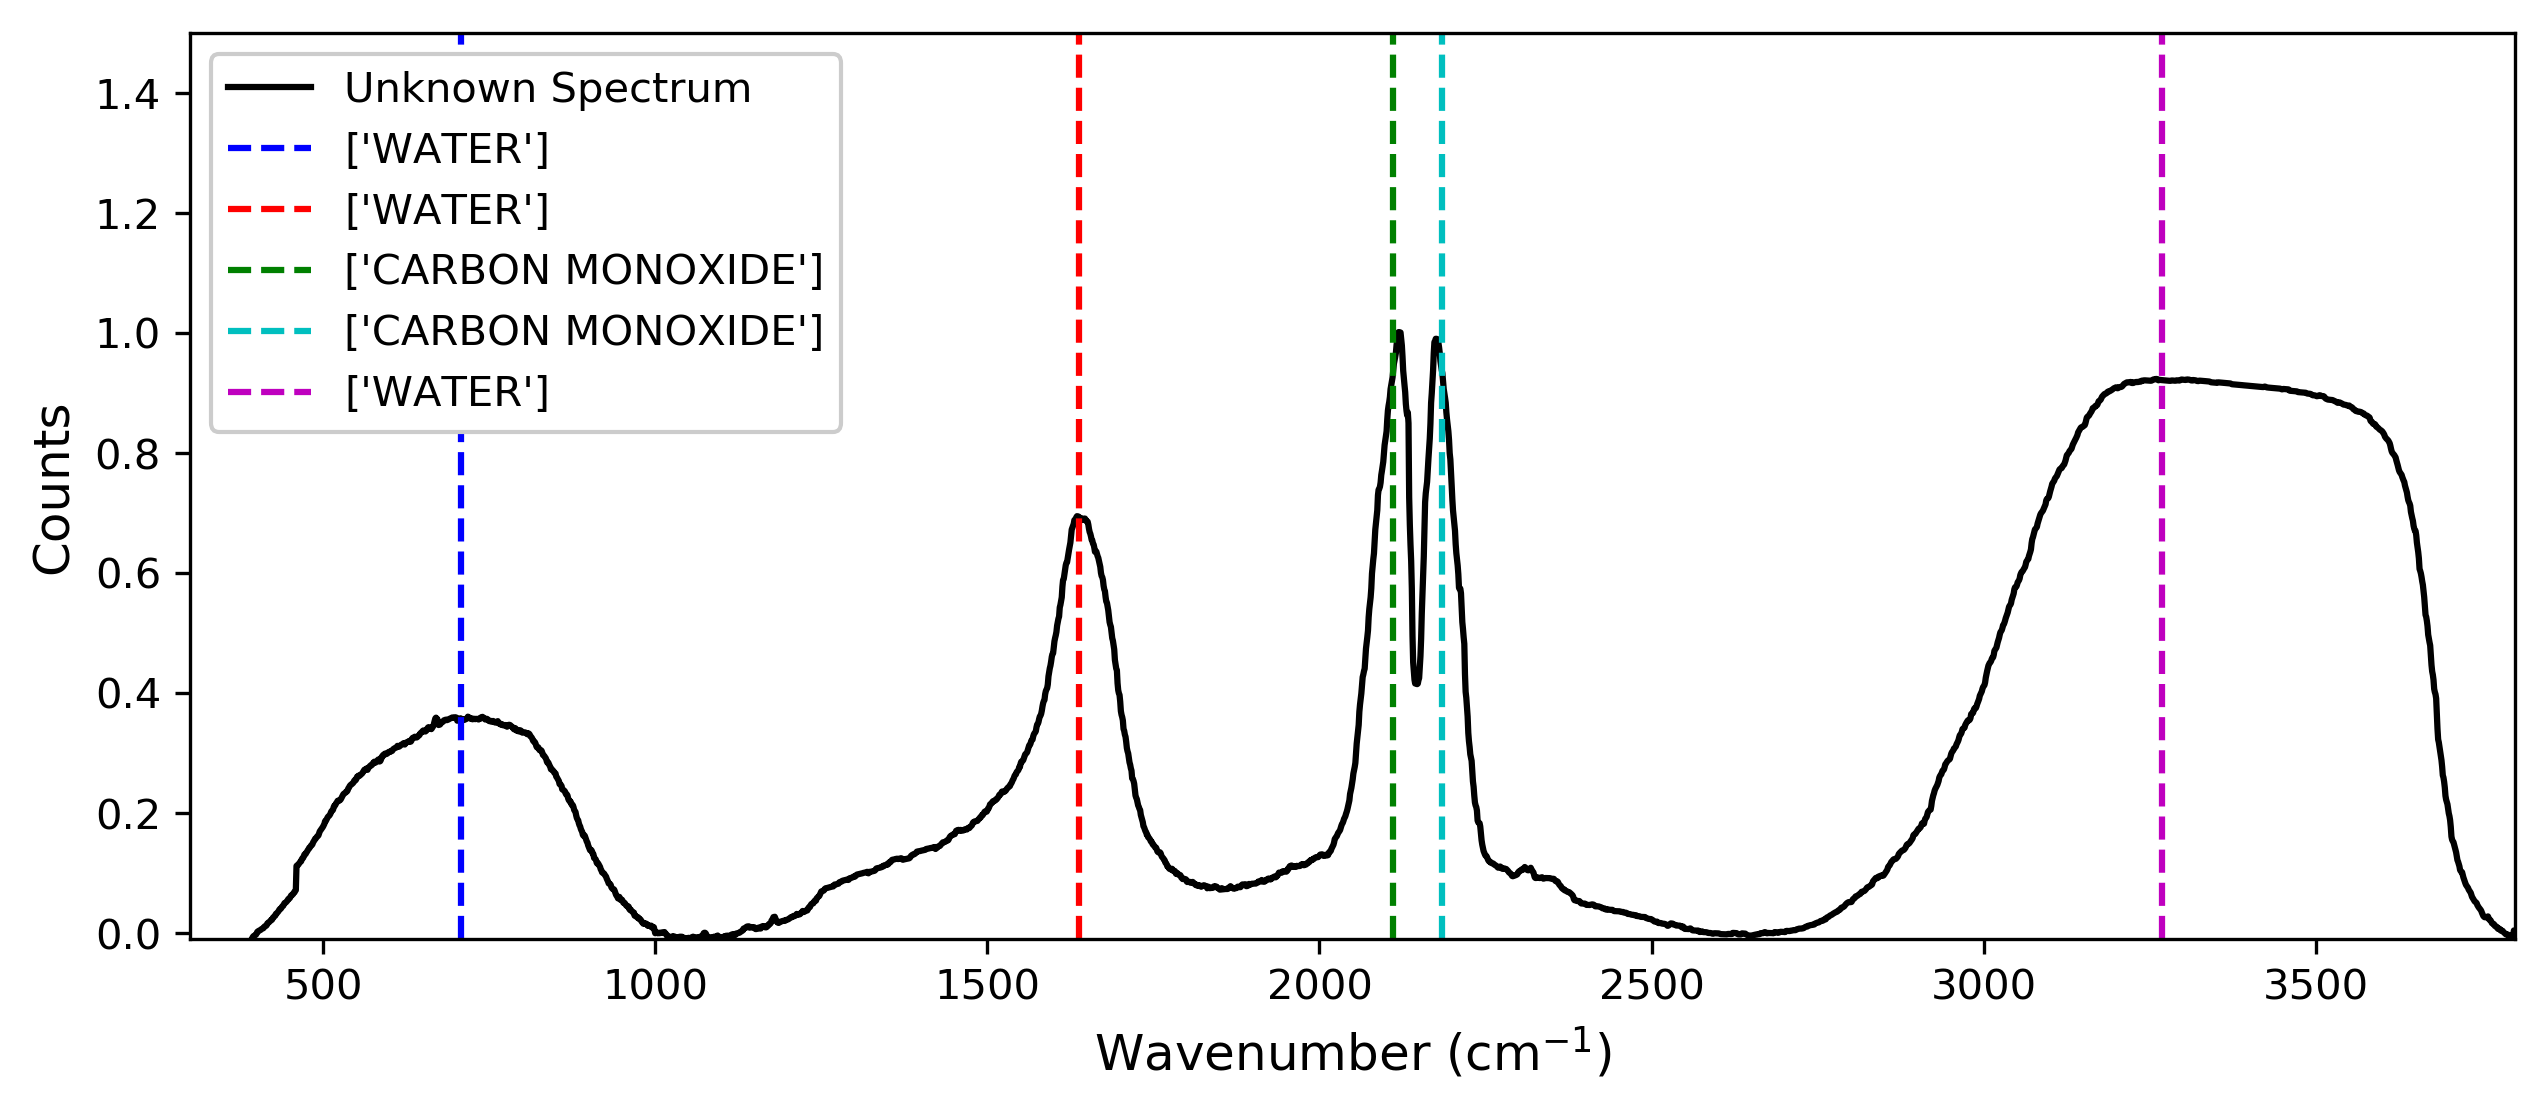

{'WATER': 100.0, 'CARBON MONOXIDE': 100.0}


In [78]:
known_compound_list = [compound_1, compound_2]
peak_assignment(spectra_x, spectra_y, known_compound_list)

The peaks that we found for WATER are: 
[711.4826030832157, 1638.6886199554203, 3312.1231809302135]
The peaks that we found for CARBON MONOXIDE are: 
[2109.8548231081886, 2183.58416497579]
The peaks that we found for FORMIC ACID are: 
[639.4717630407281, 700.0006725956375, 916.1238150000007, 1087.4292631196167, 1110.229302896255, 1120.6184463323998, 1211.60193448746, 1365.6941683529176, 1531.5978300000031, 1556.2422171904652, 1664.266539247223, 1732.780516872577, 1765.3434260000004, 1791.8601399436195, 2954.071404999994, 3117.188835832671]
[['WATER', 'FORMIC ACID'], ['WATER', 'FORMIC ACID'], ['CARBON MONOXIDE'], ['CARBON MONOXIDE'], ['WATER']]


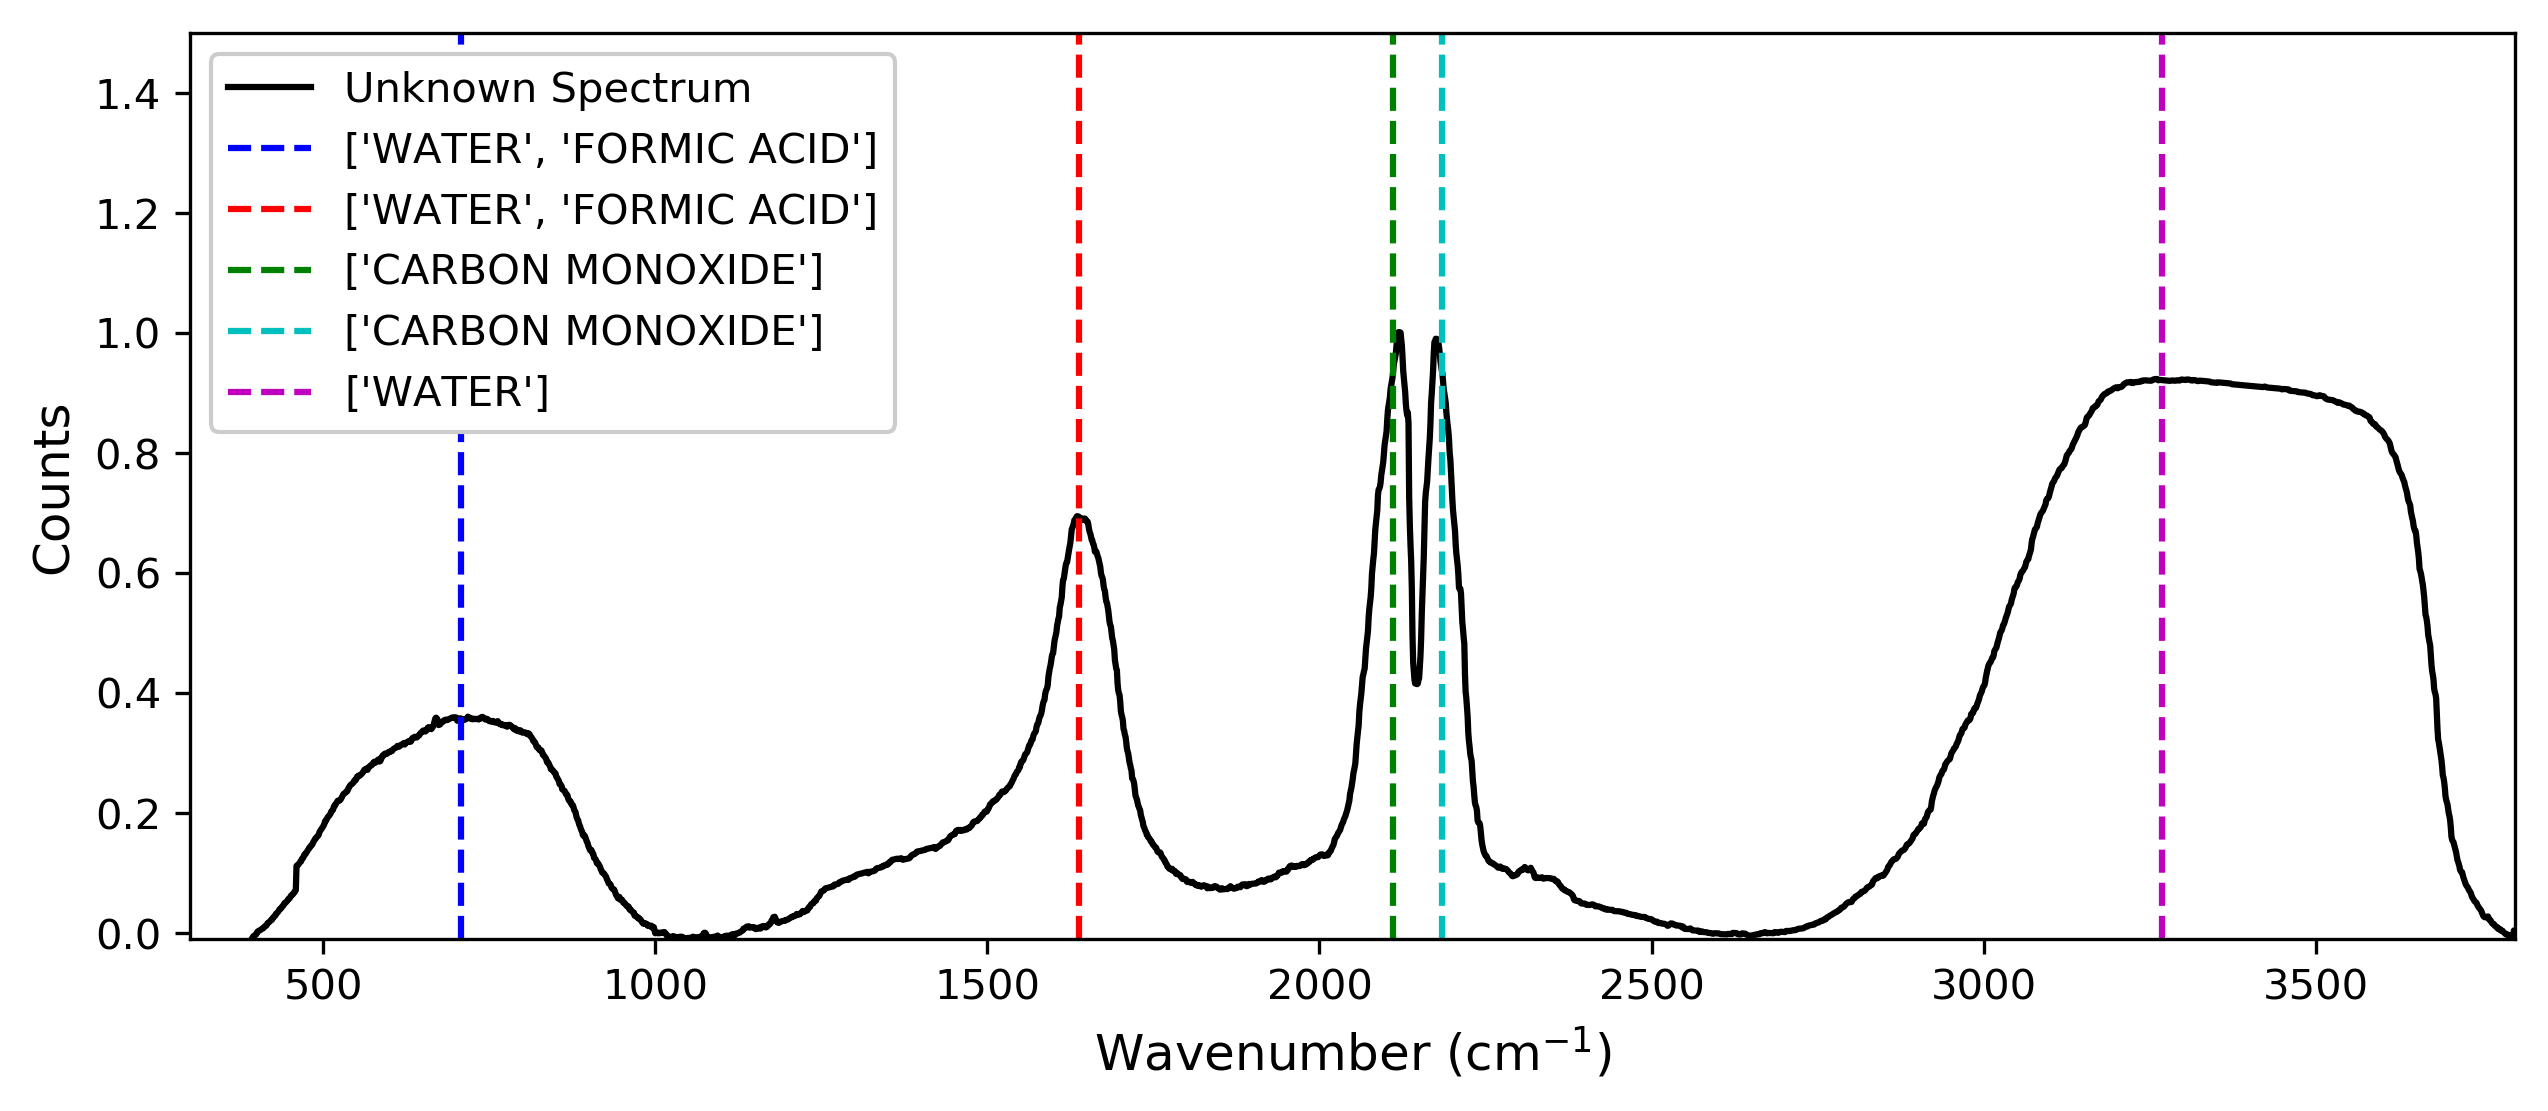

{'WATER': 100.0, 'CARBON MONOXIDE': 100.0, 'FORMIC ACID': 12.5}


In [80]:
known_compound_list_2 = [compound_1, compound_2, compound_4]
peak_assignment(spectra_x, spectra_y, known_compound_list_2)

### Alrighty. We did ok there, and it handles the problem of having multiple possible compounds for a single peak in an acceptable way for now. Next step is to handle conflicts correctly

***

### Ok, next step. Let's figure out the percentage of all peaks of a material that are found in the unknown material. 

In [44]:
#Ok, instead of what I've done here, I should use the assignment matrix to classify percentages. 
def percentage_of_peaks_found(known_peaks, association_matrix, list_of_known_compounds):
    """This function takes in a list of classified peaks, and returns a percentage of how many of the material's
    peaks are found in the unknown spectrum. This can be used as a metric of confidence."""
    percentage_dict = {}
    for i in range(len(list_of_known_compounds)):
        count_number = sum(association_matrix[i])
        percentage_dict[list_of_known_compounds[i]['title']] = (count_number/len(known_peaks[i]))*100
        
    return percentage_dict

In [79]:
def plotting_peak_assignments(unknown_x, unknown_y, unknown_peaks, unknown_peak_assignments):
    """This function plots a set of unknown peaks, and plots the assigned classification given by
    the functions within peakassignment"""
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'b']
    fig = plt.figure(figsize = (10,4), dpi = 300)
    plt.plot(unknown_x, unknown_y, color = 'black', label = 'Unknown Spectrum')
    for i in range(len(unknown_peaks)):
        plt.axvline(x = unknown_peaks[i], color = colors[i], label = unknown_peak_assignments[i], linestyle = '--')
    plt.legend(loc=0, framealpha=1)
    plt.xlabel('Wavenumber (cm$^{-1}$)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.ylim(-0.01, 1.5)
    plt.xlim(300,3800)
    plt.show()

In [ ]:
#Next, we'll need to look at the combined spectra peaks and try to ascribe the peaks. 
#I think we'll need to tell it if it sees the water peaks first.
#ie, write the function as though we'll tell it exactly what to look for first. 

#add new column to label what spectra each peak in the analyzed spectra is coming from. I think that means we 
#need to switch over to a pandas dataframe, rather than a numpy array. 


#We could loop through and check each position of the spectra peaks. At each position, we could look through all 
#of the user inputted peaks that are worth comparing(ie, define as a function, and have possible_peaks be an
#array of compounds to take as an input.) At peak position 1, we could look through and say ok, we've got 
#5 compounds in the testing function. Lets compare the peak max at peak position 1 from testing spectra against
#the first peak in every one of the compounds on the test list. If the isclose statement evaluates to true, then
#We will iterate down spectra_peaks and compare that next peak against the second peak in the tested spectra
#If we get through the whole of the spectra_peaks and don't find any more matches, then we know that the tested compound 
#was a no, and we need to 1. ignore it for all future comparisons, and 2. not assign the first peak to be coming from 
#the tested compound. 
#Then, we'll need to keep moving down our inputted list, and comparing each first peak in the inputted list against 
#our first peak. 
#If we can't find a match to the first peak, we then have a statement that assigns the first peak to "Not found!"
#Print out a small error, but then move to the second peak. We might at least be able to define some of the peaks in 
#the spectrum. 

# solicit_user_input(Is peak x close enough to peak y.)
#Alternative would be to report an prediction in terms of a percentage of the fit. That relies on Brandon's work. 

### Like Jon mentioned, we should also take a look at reporting the prediction of the peak in terms of fit confidence. 

***

### In future work, we would like to use the Bayesian Error Criterion to help error analysis on the peak fit, but for right now, we will provide a simplistic 1D Euclidean distance calculation. The reciprocal of the distance is returned as a percentage of distance comparison in the x dimension with 1 equalling peak centers that are super close and 0 super far away respectively.

***

### This scoring function also includes the user input for the choice of normalizing the peak distance scores and sorting them based on the max peak score (closest peaks) or a kth max peak. This normalization is performed to bring a better understanding to the peak distance confidence score, and it also allows for future work to be done in determining the best kth max peak to be used.

In [10]:
def peak_1D_score(rowA,rowB,scoremax):
    """
    Returns scores with respect to the repricoal of the 
    calculated Euclidean distance between peaks
    #√((x1-x2)^2) in 1D
    #√((x1-x2)^2 + (y1-y2)^2) in 2D

    Parameters:
        row A (list):  input list
        row B (list): input list
        scoremax (float): Euclidean reciprocal score divided by max score

    Returns:
        scores (list): Euclidean reciprocal scores
        peaks (tuple): peaks associated with scores
    """
    scores = []
    peaks=[]
    

    for i in range(len(rowA)):
        for j in range(len(rowB)):
            distance = np.where((rowA[i] - rowB[j]>50),np.nan,math.sqrt(sum([math.pow(rowA[i] - rowB[j], 2)])))
            if (1/(distance + 1)>.02): # Score for peaks less than 50 units apart
                scores.append((((1/(distance + 1))/scoremax)))
                peaks.append((rowA[i],rowB[j]))
            else:
                pass
    return scores,peaks

def score_max(list_input, row,k):
    """
    Returns list of scores with respect to its output max score

    Parameters:
        list_input (list):  input list
        row (list): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        maxscores (list): Euclidean reciprocal score divided by max score
        maxpeaks (tuple): peaks associated with max scores
    """
    try:
        maxscores,maxpeaks = peak_1D_score(list_input,row,sorted(set(peak_1D_score(list_input,row,1)[0][:]))[-k])
    
    except Exception as e:
        
        maxscores,maxpeaks = peak_1D_score(list_input,row, scoremax=1)
        
    return maxscores,maxpeaks
def score_sort(list_input, row,k):
    """
    Returns list of scores sorted

    Parameters:
        list_input (list):  input list
        row (list): input list
        k (int): input integer used to sort the scores / kth highest score

    Returns:
        sortedscores (list): sorted Euclidean distances
    """
    sortedscores = []
    sortedscores.append(score_max(list_input,row,k))
    sortedscores.sort()
    return sortedscores

In [ ]:
def test_peak_1D_score():
    """Evaluates the functionality of the peak_1D_score function"""
    # Initialize the test arguments 
    row_i=[0,1]
    row_j=[2,1]
    # Run Function
    testscore=peak_1D_score(row_i,row_j,1)[0][:]
    testpeaks=peak_1D_score(row_i,row_j,1)[1][:]
    # make assertions
    assert len(row_i) == len(row_j), 'Input lengths do not match'
    assert testscore <= .02, 'Output value outside acceptable range'
    assert isinstance(testscore, np.int), 'Output is not a numpy.float'

def test_score_max():
    """Evaluates the functionality of the score_max function"""
    # Initialize the test arguments 
    maxscores,maxpeaks = peak_1D_score(list_input,row,sorted(set(peak_1D_score(list_input,row,1)[0][:]))[-k])
    # Run Function
    assert len(d_train.index) == len(sorteddistances), 'Output array length different than DataFrame length'
    # make assertions
    
    return maxscores,maxpeaks
def test_score_sort(list_input, row,k):
    """Evaluates the functionality of the score_sort function"""
    # Initialize the test arguments 
    sortedscores = []
    # Run Function
    sortedscores=score_sort(list_input, row,k)
    # make assertions
    sortedscores.sort()
    return sortedscores

In [ ]:
water_peaks = spectrafit.compound_report(compound_1)
co_peaks = spectrafit.compound_report(compound_2)
co2_peaks = spectrafit.compound_report(compound_5)
spectra_peaks = spectrafit.data_report(spectra_x, spectra_y)